The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-tvm
!pip install mxnet-cu100
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/tvm-0.7.dev1-cp37-cp37m-linux_x86_64.whl https://tvm-repo.s3-us-west-2.amazonaws.com/topi-0.7.dev1-py3-none-any.whl


# Batch Norm
:label:`ch_batch_norm_gpu`

This section talks about batch normalization defined in :numref:`ch_batch_norm` on GPU.

## Setup

In [1]:
%matplotlib inline
import tvm
from tvm import te
import numpy as np
import d2ltvm
import mxnet as mx
import timeit 

target = 'cuda'

## Schedule

In order to schedule the batch normalization on GPU, we first fuse the stages using `te.schedule.AutoInlineInjective`. By doing so, we end up one loop nest that we can easily parallelize (via binding CUDA blocks) and vectorize (via binding CUDA threads).
Each CUDA thread operates on a series of numbers as what we did for convolution in :numref:`ch_conv_gpu`.
This is the simple default schedule we can get for batch normalization.
The code snippet below does it and prints out the corresponding IR. It should be clear to you so far.

In [2]:
size = (32, 112)

def default_bn(size):
    c, n = size[:]
    X, Mean, Var, Gamma, Beta, Y = d2ltvm.batch_norm(c, n)
    sch = te.create_schedule(Y.op)
    te.schedule.AutoInlineInjective(sch)
    c, h, w = Y.op.axis[0:3]
    sch[Y].bind(c, te.thread_axis("blockIdx.x"))
    sch[Y].bind(h, te.thread_axis("threadIdx.x"))
    return sch, (X, Mean, Var, Gamma, Beta, Y)

sch, args = default_bn(size)
print(tvm.lower(sch, args, simple_mode=True))

produce T_add {
  // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 32
  // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 112
  for (ax2, 0, 112) {
    T_add[(((blockIdx.x*12544) + (threadIdx.x*112)) + ax2)] = ((((X[(((blockIdx.x*12544) + (threadIdx.x*112)) + ax2)] - Mean[blockIdx.x])/sqrt((Var[blockIdx.x] + 1e-05f)))*Gamma[blockIdx.x]) + Beta[blockIdx.x])
  }
}



An alternative scheduling scheme is to fuse all axes of the loop nest and restructure it into a 2-level for loop, where the inner one binds to CUDA threads and the outer one binds to CUDA blocks.
The number of CUDA threads of a block is set to be the maximum, as we did in :numref:`ch_pooling_gpu`. The code snippet below does it and prints out the corresponding IR.

In [3]:
nt = 0
with tvm.target.create(target):
    nt = tvm.target.Target.current(allow_none=False).max_num_threads

def optimized_bn(size):
    c, n = size[:]
    X, Mean, Var, Gamma, Beta, Y = d2ltvm.batch_norm(c, n)
    sch = te.create_schedule(Y.op)
    te.schedule.AutoInlineInjective(sch)
    fused = sch[Y].fuse(*sch[Y].op.axis)
    bx, tx = sch[Y].split(fused, factor=nt)
    sch[Y].bind(bx, te.thread_axis("blockIdx.x"))
    sch[Y].bind(tx, te.thread_axis("threadIdx.x"))
    return sch, (X, Mean, Var, Gamma, Beta, Y)

sch, args = optimized_bn(size)
print(tvm.lower(sch, args, simple_mode=True))

produce T_add {
  // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 392
  // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 1024
  T_add[((blockIdx.x*1024) + threadIdx.x)] = ((((X[((blockIdx.x*1024) + threadIdx.x)] - Mean[floordiv(((blockIdx.x*1024) + threadIdx.x), 12544)])/sqrt((Var[floordiv(((blockIdx.x*1024) + threadIdx.x), 12544)] + 1e-05f)))*Gamma[floordiv(((blockIdx.x*1024) + threadIdx.x), 12544)]) + Beta[floordiv(((blockIdx.x*1024) + threadIdx.x), 12544)])
}



In this specific case, as the total number of entries ($32\times28\times28=25088$) cannot be divided  by `max_num_threads` ($1024$), we see the `if` statement in the IR to guard the boundary. 
The term `likely` in the `if` statement indicates the compiler for better speculation.
Another new keyword we see in the IR is `floordiv`, which is introduced to guide the access pattern.
Note that for batch normalization, we have the same `Mean`, `Var`, `Gamma`, and `Beta` values for the same channel.
When different channels are located in the same CUNDA block, we will need an extra calculation to locate the correct values.

In general, we want to avoid the above additional steps if possible. However, in this case, as batch normalization is memory-bound, having more CUDA threads in a block, and correspondingly having more data shared in a block, is more important.

You may also notice that we do not use the `cache_read` and `cache_write` primitives to optimize the schedule. This is also due to the memory-bound nature of batch normalization, bringing data to local memory would not help much.

## Benchmark

We use MXNet as the baseline to check the performance of batch normalization we achieve using TVM.
The benchmarking methods were defined in :numref:`ch_batch_norm_cpu`.
We plot the absolute times of the MXNet baseline and the two scheduling schemes described above, as functions of varied channels.

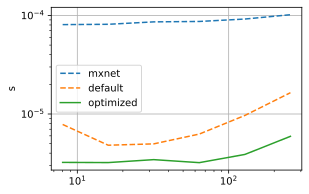

In [4]:
channels = 2**np.arange(3, 9, 1)
sizes = [(int(c), 28) for c in channels]
default_times = d2ltvm.bench_bn_tvm(default_bn, sizes, target)
optimized_times = d2ltvm.bench_bn_tvm(optimized_bn, sizes, target)
mxnet_times = d2ltvm.bench_bn_mxnet(sizes, ctx='gpu')
times = [mxnet_times, default_times, optimized_times]
d2ltvm.plot(channels, times, ylabel='s',
            xscale='log', yscale='log',
            legend=['mxnet', 'default', 'optimized'], fmts=['--']*(len(times)-1)+['-'])

The results show that even with `if` statement and `floordiv`, the optimized schedule executes faster than the default the schedule for batch normalization.
The batch normalization performance of MXNet is much worse, likely to be dominated by the function call overhead.

## Summary

- Optimizing batch normalization on GPU is all about block and thread binding.
- For small operators, having additional steps in IR is acceptable as long as the number of CUDA threads in a CUDA block can be maximized.

## Exercise

- Try to eliminate the `if` statement and `floordiv` from the IR generated by the optimized scheduling scheme of batch normalization, and check out the performance.
- Try to use `cache_write` to schedule batch normalization and observe the performance difference, if any, it brings.